In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 16, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!
# clover_term = clover.add_I(clover=torch.zeros_like(clover_term))  # test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=verbose, max_iter=50, max_restarts=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8]]
local_ortho_null_vecs.shape,src_c.shape,dest_f.shape:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), torch.Size([12, 8, 8, 8, 8]), torch.Size([12, 16, 16, 16, 16]))
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
_src_f.shape:torch.Size([12, 16, 16, 16, 16])
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
_src_f.shape:torch.Size([12, 16, 16, 16, 16])
restrict:shape,co

In [3]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [4]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

BICGSTAB:Iteration 0: Residual = 2.827851e+02, Time = 0.033411 s
BICGSTAB:Iteration 1: Residual = 1.175370e+02, Time = 0.034588 s
BICGSTAB:Iteration 2: Residual = 1.200083e+02, Time = 0.034175 s
BICGSTAB:Iteration 3: Residual = 7.268095e+01, Time = 0.030928 s
BICGSTAB:Iteration 4: Residual = 4.451652e+01, Time = 0.033119 s
BICGSTAB:Iteration 5: Residual = 3.966973e+01, Time = 0.033488 s
BICGSTAB:Iteration 6: Residual = 2.442306e+01, Time = 0.034355 s
BICGSTAB:Iteration 7: Residual = 1.880193e+01, Time = 0.036574 s
BICGSTAB:Iteration 8: Residual = 2.299062e+01, Time = 0.034524 s
BICGSTAB:Iteration 9: Residual = 4.594438e+01, Time = 0.034249 s
BICGSTAB:Iteration 10: Residual = 3.005082e+02, Time = 0.032236 s
BICGSTAB:Iteration 11: Residual = 2.790928e+02, Time = 0.035837 s
BICGSTAB:Iteration 12: Residual = 6.150482e+01, Time = 0.034880 s
BICGSTAB:Iteration 13: Residual = 1.668010e+01, Time = 0.036576 s
BICGSTAB:Iteration 14: Residual = 1.563908e+01, Time = 0.033241 s
BICGSTAB:Iteration 1


MG:Iteration 1:
V-cycle level 0, mg_size: [16, 16, 16, 16]
    Pre pre-smooth residual norm: 1.3307e+03
    Pre-smoothing...
    Post pre-smooth residual norm: 8.2705e+01
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
V-cycle level 1, mg_size: [8, 8, 8, 8]
    Pre-solve residual norm: 2.2483e+02
    Solving coarsest grid directly...

Performance Statistics:
Total iterations: 5
Total time: 0.016943 seconds
Average time per iteration: 0.003385 s
Final residual: 7.28e-07
    Post-solve residual norm: 2.3568e-05
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
    Post post-smooth residual norm: 8.3813e+01
MG:Iteration 1 completed, residual norm: 8.3813e+01

MG:Iteration 2:
V-cycle level 0, mg_size: [16, 16, 16, 16]
    Pre pre-smooth residual norm: 8.3813e+01
    Pre-smoothing...
    Post pre-smooth residual norm: 1.4463e+01
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 2, 8

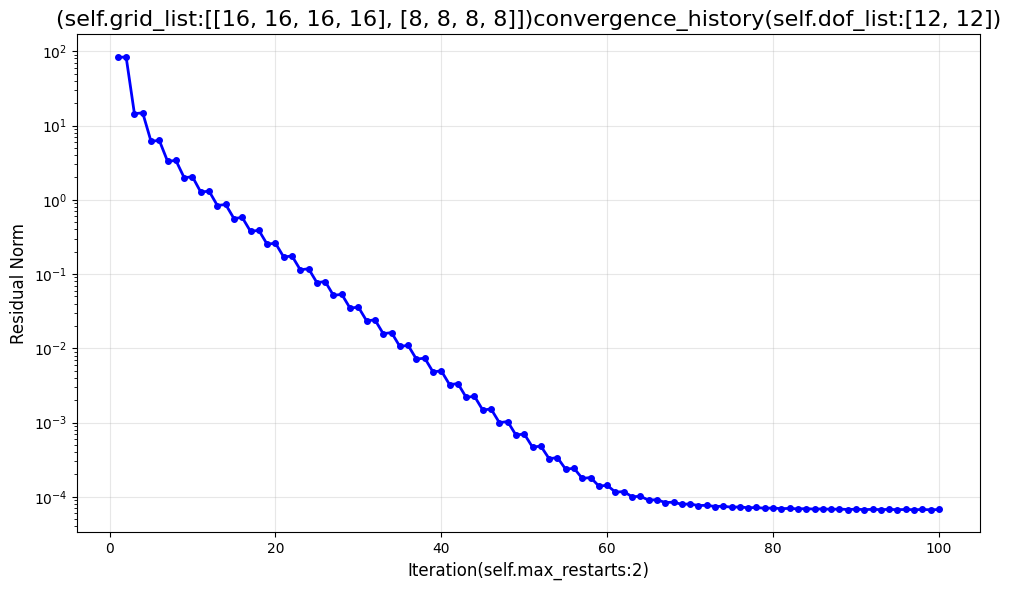

In [5]:
x = mg.solve()
mg.plot()

In [6]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

5.016371100365011e-07


In [7]:
mg.b_list[-1].flatten()[:100]

tensor([ 5.2443e-08+1.0959e-08j,  1.6455e-08-3.1419e-08j,
         3.1378e-08+7.6674e-09j, -6.6286e-08-5.2975e-09j,
         8.6341e-08+6.6108e-08j, -6.5048e-08+4.2820e-09j,
        -5.7525e-08-2.5260e-08j, -9.9721e-09+9.3636e-09j,
        -3.7842e-09+1.5989e-08j,  2.6058e-08-1.0038e-07j,
        -2.9453e-09-1.6886e-08j,  2.2997e-08-3.9833e-08j,
         7.2996e-08+5.0308e-08j,  4.1109e-09+4.3091e-08j,
        -7.4735e-08-7.7986e-08j,  7.9230e-09-5.0408e-08j,
         6.3509e-08+8.2230e-08j,  1.0491e-07+3.7559e-08j,
        -6.2312e-08-6.0184e-08j, -6.6990e-08-5.6391e-08j,
        -1.0251e-07+2.4016e-08j,  1.9617e-08+6.9464e-09j,
        -3.4342e-08-4.1148e-08j, -3.3087e-08+1.3637e-08j,
         2.4670e-08+4.4843e-08j,  5.9790e-08-7.5718e-08j,
         1.2266e-08+7.4720e-09j, -2.1284e-08-5.7937e-08j,
        -1.6110e-08+8.5527e-08j, -9.1040e-08-2.7739e-08j,
         7.1603e-09-1.5917e-07j, -2.5533e-08-1.5758e-08j,
        -3.2518e-08+3.9526e-08j, -4.7094e-08-3.0990e-08j,
        -3.282

> 0. 所有部分均构建完成......
> 1. 按null_vecs生成的test_vecs负优化明显，随机生成反而更适用
> 2. smooth后residual过小，消去低频误差效果较差
> 3. 遍历不同的dof_list，smooth方案，没有发现明显正优化
> 4. 尝试了amg与gmg（通过修改test_vecs实现）......